In [ ]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import re

In [147]:
def generate_trials_csv(
    path: str,
    v_min=-10.0, v_max=10.0,
    num_conditions=200,
    s2_std_max=8.0, std_step=1,
    trials_per_condition=100,
):
    values = np.linspace(v_min, v_max, num_conditions)
    s2_stds = np.arange(1, s2_std_max + std_step/2, std_step)

    with open(path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Trial","S1_val","S1_std","S2_val","S2_std"])

        trial_id = 1

        for v in values:
            for s2 in s2_stds:
                for _ in range(trials_per_condition):
                    writer.writerow([
                        trial_id,
                        f"{v:.2f}",  "0.00",    # S1_val, S1_std
                        f"{v:.2f}",  f"{s2:.2f}"  # S2_val, S2_std
                    ])
                    trial_id += 1
    
    print(f"values saved in: {path}")

In [148]:
generate_trials_csv("bayes/level_1_exp_input_100.csv")

values saved in: bayes/level_1_exp_input_100.csv


In [144]:
def plot_psychometric(csv_path):
    df = pd.read_csv(csv_path)

    # Convert numeric columns
    df["S2_val"] = df["S2_val"].astype(float)
    df["S2_std"] = df["S2_std"].astype(float)

    # Compute probability per condition
    grouped = (
        df.groupby(["S2_val", "S2_std"])["Decision (S1>S2)"]
        .agg(["mean", "count"])
        .reset_index()
    )

    plt.figure(figsize=(8, 6))

    for std in sorted(grouped["S2_std"].unique()):
        #sort the curve by s2_value so the x-axis is in the correct order
        subset = grouped[grouped["S2_std"] == std].sort_values("S2_val")

        # ---- Find x50 (closest to 0.5) ----
        idx = np.abs(subset["mean"] - 0.5).idxmin()
        threshold_val = subset.loc[idx, "S2_val"]

        # ---- Estimate slope at x50 using local regression ----
        # take up to 3 nearest points: one before, one at, one after
        i = subset.index.get_loc(idx)
        window = subset.iloc[max(i-1,0) : i+2]

        # Fit a line: mean = a*S2_val + b
        coef = np.polyfit(window["S2_val"], window["mean"], 1)
        slope = coef[0]

        # ---- Convert slope → variance ----
        if slope != 0:
            sigma = 1 / (np.sqrt(2*np.pi) * abs(slope))
            variance = sigma**2
        else:
            variance = np.nan

        # ---- Plot ----
        plt.plot(
            subset["S2_val"],
            subset["mean"],
            marker=".",
            label=f"σ={std} (x50={threshold_val:.2f}, Var≈{variance:.3f})"
        )

    plt.legend(title="S2_std", fontsize=8, loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.xlabel("Stimulus value (S2_val)")
    plt.ylabel("P(response = 1)")
    plt.title("Psychometric Function")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

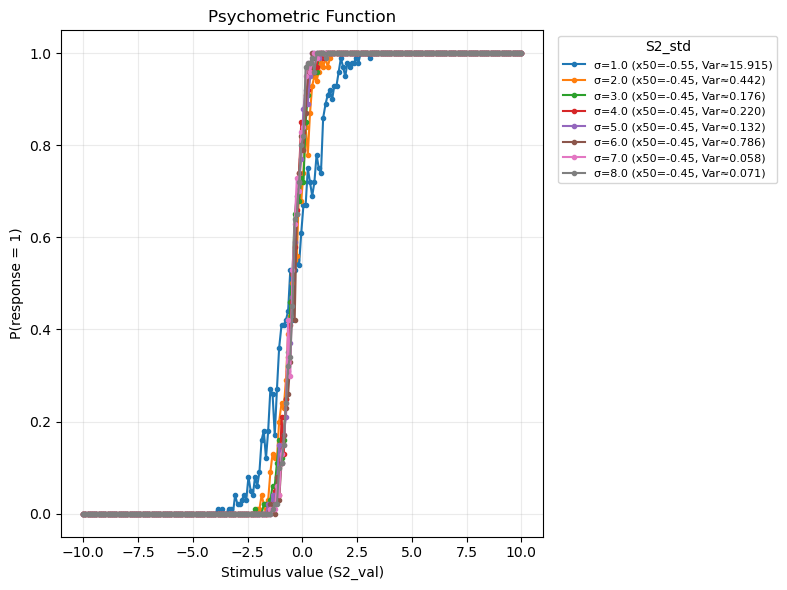

In [150]:
plot_psychometric("/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_1_results.csv")

In [ ]:
def extract_prior_means(csv_path):
    """
    For a single CSV file:
      - compute mean response per (S2_val, S2_std)
      - find x50 for each S2_std
      - return a DataFrame with columns:
            ["file_id", "S2_std", "x50"]
    """

    df = pd.read_csv(csv_path)

    # Parse training period from filename (lvl_5_results_500.csv → 500)
    m = re.search(r"(\d+)\.csv$", csv_path)
    file_id = int(m.group(1)) if m else None

    # Ensure numeric
    df["S2_val"] = df["S2_val"].astype(float)
    df["S2_std"] = df["S2_std"].astype(float)

    # Probability per condition
    grouped = (
        df.groupby(["S2_val", "S2_std"])["Decision (S1>S2)"]
        .mean()
        .reset_index()
    )

    results = []

    for std in sorted(grouped["S2_std"].unique()):
        subset = grouped[grouped["S2_std"] == std].sort_values("S2_val")

        # Find x50 = S2_val where mean is closest to 0.5
        idx = np.abs(subset["Decision (S1>S2)"] - 0.5).idxmin()
        x50 = subset.loc[idx, "S2_val"]

        results.append({
            "file_id": file_id,
            "S2_std": std,
            "x50": x50
        })


    return pd.DataFrame(results)

In [49]:
def extract_across_files(file_paths):
    all_results = []

    for path in file_paths:
        df_res = extract_prior_means(path)
        all_results.append(df_res)

    return pd.concat(all_results, ignore_index=True)

In [155]:

def plot_prior_means(df_results):
    """
    df_results must have:
        file_id | S2_std | x50
    (output of extract_across_files)
    """

    plt.figure(figsize=(8, 5))


    for std in sorted(df_results["S2_std"].unique()):
    

        subset = df_results[df_results["S2_std"] == std].sort_values("file_id")

        plt.plot( subset["file_id"], subset["x50"], marker=".", label=f"S2_std = {std}" )

    plt.xlabel("training trial")
    plt.ylabel("Prior mean estimate")
    plt.title("Inferred Prior Mean across Training")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Noise level (S2_std)")
    plt.tight_layout()
    plt.show()

In [160]:
paths = sorted(
    glob.glob("/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_*.csv"),
    key=lambda p: int(re.search(r"(\d+)\.csv$", p).group(1))
    )
print(paths)

df_all = extract_across_files(paths)
print(df_all)


['/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_0.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_10.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_20.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_50.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_100.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_200.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_300.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_400.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_500.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_600.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_800.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_1000.csv', '/Users/arielventura/cog-sup/cogsup-prog/bayes/lvl_5_results_1001.csv']
     file_id  S2_std   x50
0          0     1.0  3.87
1          0     2.0  3.8

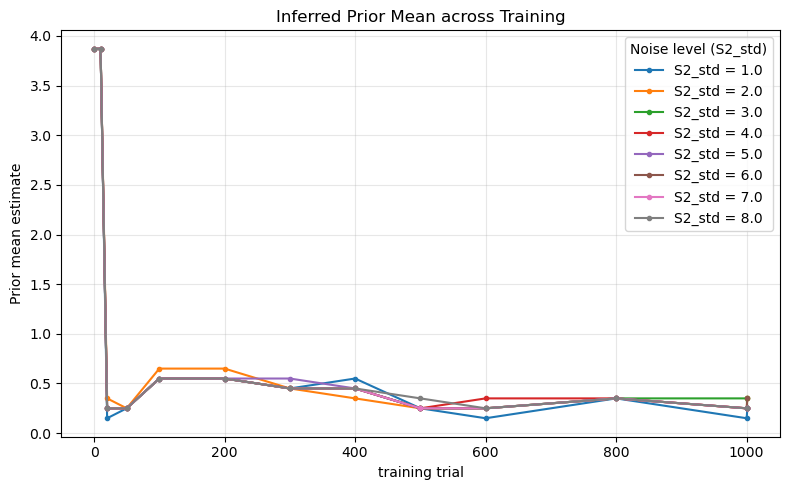

In [161]:
plot_prior_means(df_all)

In [108]:
def plot_mu_prior(csv_path):
    df = pd.read_csv(csv_path)

    # ensure numeric, remove commas/spaces if needed
    df["mu_prior"] = df["mu_prior"].astype(float)
    df["Trial"] = df["Trial"].astype(int)

    plt.figure(figsize=(8, 5))
    plt.plot(df["Trial"], df["mu_prior"], linewidth=1)

    plt.xlabel("Trial")
    plt.ylabel("mu_prior")
    plt.title("Evolution of Mu_Prior Across Trials")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

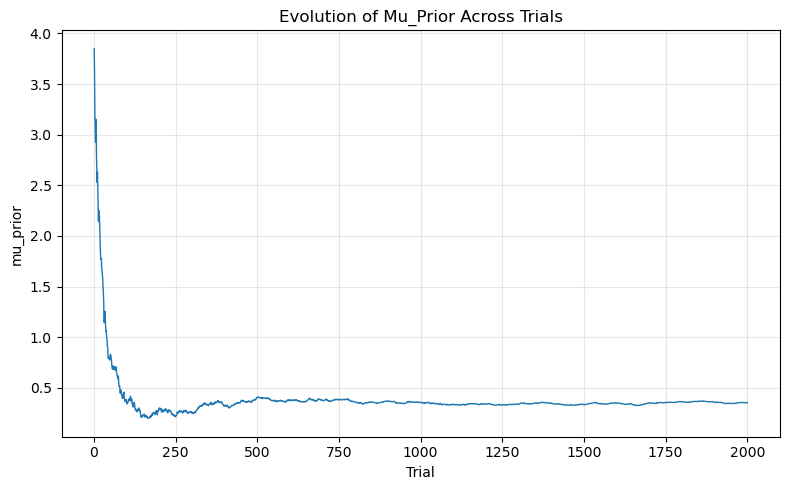

In [113]:
plot_mu_prior("/Users/arielventura/cog-sup/cogsup-prog/bayes/training_history.csv")